# Example notebook for:

# Marine cloud base height retrieval from MODIS cloud properties using machine learning

Lenhardt, J. (1), Quaas, J. (1, 2), Sejdinovic, D. (3)

1 Leipzig Institute for Meteorology, Leipzig University, Leipzig, Germany

2 ScaDS.AI - Center for Scalable Data Analytics and Artificial Intelligence, Leipzig University, Humboldtstraße 25, 04105 Leipzig, Germany

3 School of Computer and Mathematical Sciences & Australian Institute for Machine Learning, University of Adelaide, Adelaide, Australia


##### Notebook edited by Julien LENHARDT

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

home_dir = os.getcwd()

DATA_DIR = home_dir + '/data/example/'
METHOD_DIR = home_dir + '/method/'
MODELS_DIR = home_dir + '/method/models/models_save/'

from method.utils.utils import sample_tiles_swath, plot_tile, tile_predict_cbh, CloudBaseHeightPrediction

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Example for swath file A2008.010.1245.nc

### Process swath file
Create corresponding tiles of size (128 km x 128km) of cloud properties = cloud top height, cloud optical thickness and cloud water path.
Sample the tiles randomly from the swath or with regular spacing. In the case of regular sampling, one can choose how to space the sampled tiles through the 'sampling_step' parameter ('wide' = 128 km, 'regular' = 64 km, 'fine' = 10 km, these values can be adapted in the code to suit your needs). In the case of regular sampling, the parameter 'n_tiles' is of no importance.

In [3]:
swath = 'A2008.010.1245.nc'
swath_name = DATA_DIR + swath
dest_dir = DATA_DIR + 'tiles/'
regular_sampling = True
sampling_step = 'fine'
n_tiles = 20
tile_size = 128
cf_threshold = 0.3
verbose = True

In [4]:
centers = sample_tiles_swath(filename=swath_name,
                             dest_dir=dest_dir,
                             regular_sampling=regular_sampling,
                             sampling_step=sampling_step,
                             n_tiles=n_tiles,
                             tile_size=tile_size,
                             cf_threshold=cf_threshold,
                             verbose=verbose)

Swath file A2008.010.1245
    Extracting channels and cloud mask data...
    Extracting tiles for swath A2008.010.1245 ...
    11804 extracted tiles
    Saving tiles to output directory ...


#### Plot example of extracted tiles

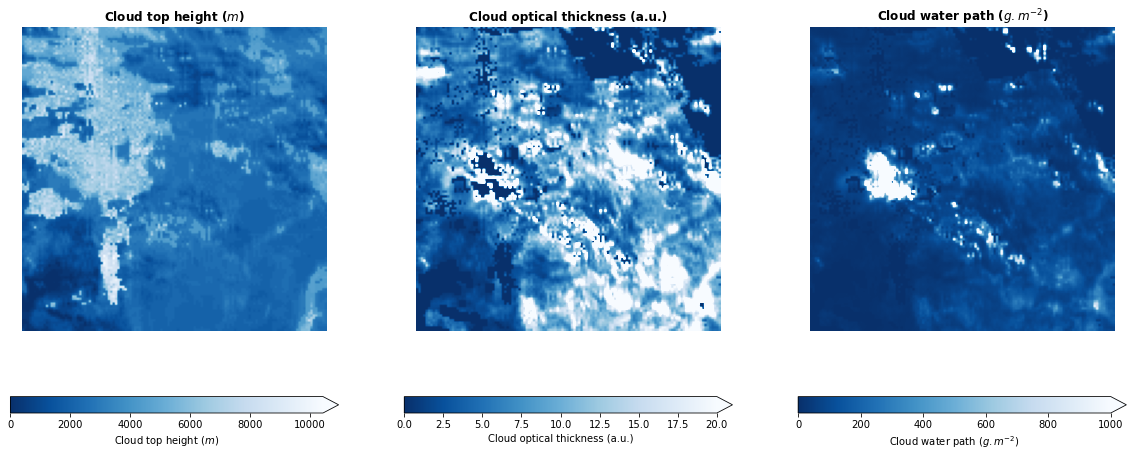

In [5]:
plot_tile(tile=dest_dir + 'A2008.010.1245_10.nc')

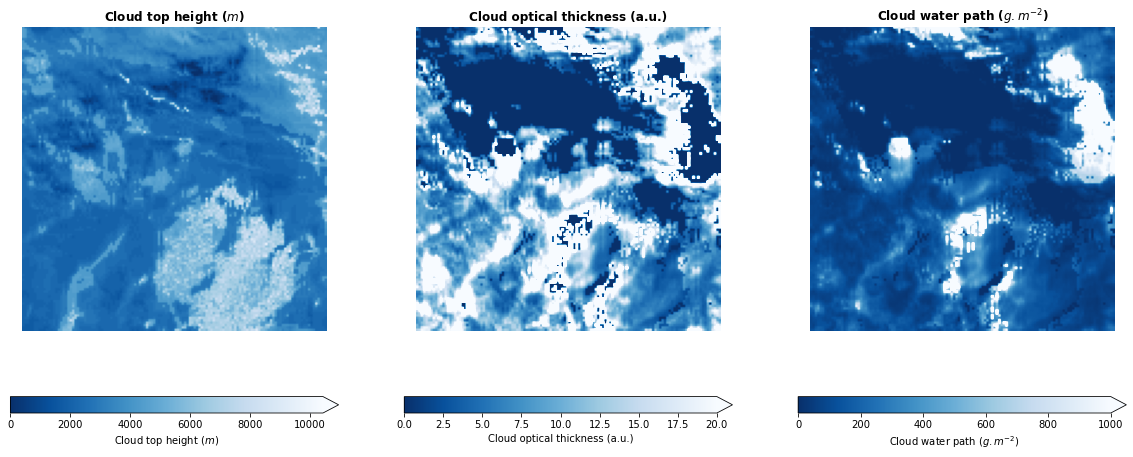

In [6]:
plot_tile(tile=dest_dir + 'A2008.010.1245_20.nc')

### Run encoding and prediction models
Load convolutional auto-encoder from file

    ae_ocean_savecheckpoint80.pt

Load ordinal regression prediction model from file

    cbh_prediction_mord_logistic_at.joblib

In [7]:
ae_model = MODELS_DIR + 'ae_ocean_savecheckpoint80.pt'
or_model = MODELS_DIR + 'cbh_prediction_mord_logistic_at.joblib'
means_stds_file = DATA_DIR + 'means_stds_save.txt' 

ddir = DATA_DIR + 'tiles/'
tile_names = 'A2008.010.1245'

In [8]:
preds, centers = tile_predict_cbh(
    ddir=ddir, tile_names=tile_names, ae_model=ae_model, or_model=or_model,
    means_stds_file=means_stds_file, verbose=True)

    Running encoding of sampled tiles...
    Predicting cloud base height...


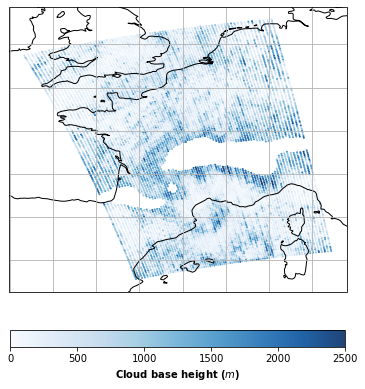

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
scat = ax.scatter(x=centers[:, 1], y=centers[:, 0],
                  s=1 if regular_sampling else 100, c=preds, vmin=0., vmax=2500.,
                  cmap='Blues', alpha=0.9)
cb = plt.colorbar(scat, orientation='horizontal', shrink=0.6, pad=0.1)
cb.set_label('Cloud base height ($m$)', weight='bold')
ax.coastlines()
ax.gridlines()
plt.savefig('/path/to/plot/directory/method_example_notebook_plot.png',
            dpi=300, bbox_inches='tight')

## Method wrapper function 

In [14]:
# Parameters
parameters = {
    'filename': DATA_DIR + 'A2008.010.1245.nc',
    'ddir': DATA_DIR + 'tiles/',
    'regular_sampling': False,
    'sampling_step': None,
    'n_tiles': 20,
    'tile_size': 128,
    'cf_threshold': 0.3,
    'ae_model': MODELS_DIR + 'ae_ocean_savecheckpoint80.pt',
    'or_model': MODELS_DIR + 'cbh_prediction_mord_logistic_at.joblib',
    'means_stds_file': DATA_DIR + 'means_stds_save.txt' ,
    'verbose': True
}

In [15]:
method = CloudBaseHeightPrediction(parameters)

In [16]:
preds = method.run_cbh()

Running cloud base height prediction pipeline...

-> Sampling tiles from swath files
Swath file A2008.010.1245
    Extracting channels and cloud mask data...
    Extracting tiles for swath A2008.010.1245 ...
    20 extracted tiles
    Saving tiles to output directory ...

-> Encoding sampled tiles and predicting cloud base height
    Running encoding of sampled tiles...
    Predicting cloud base height...

Done
